In [1]:
# Importando librerias
from __future__ import print_function, division
from PyAstronomy import pyasl
from astropy.timeseries import LombScargle
from specutils import Spectrum1D
from astropy.io import fits as pyfits
from astropy.io import fits
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns
import pandas as pd
import numpy as np
import specutils.io
import scipy as sc
from scipy.stats import norm
import csv
import os
import sys
from scipy.stats import kstest
from scipy.stats import ks_2samp
import math
from scipy import stats

## Periodograma
https://docs.astropy.org/en/stable/timeseries/lombscargle.html#peak-significance-and-false-alarm-probabilities

## Datos obtenidos de CERES (header):
Estos resultados de velocidad radial son los obtenidos directamente de CERES, es decir, los que vienen directamente del header de cada espectro.

-----------------------------------------------
Poder máximo con el dato:  4.235728738100182
Frecuencia: 0.09557439554629901 1 / d
Periodo: 10.463053355284584 d
-----------------------------------------------
Poder máximo sin el dato:  17.434465134596195
Frecuencia: 0.08993819864794252 1 / d 
Periodo: 11.118746150503167 d
-----------------------------------------------


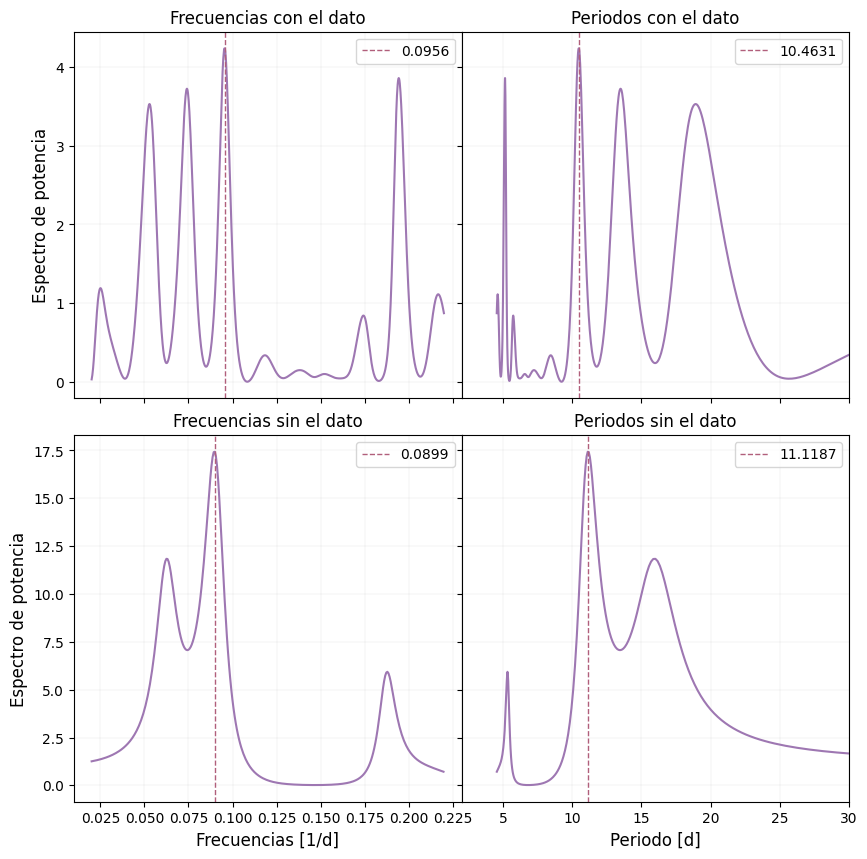

In [2]:
# Supongamos que tienes tus datos de tiempo y velocidades radiales en dos arreglos numpy, por ejemplo:
t_CERES = np.array([59616.23271964618, 59650.10320109323, 59656.0512570944, 59657.12144344438, 59658.05911761139, 59661.10135918918, 59664.12034640477, 59666.11733959911])*u.day  # Tiempo de observación
y_CERES = np.array([315.6384, 315.535700,315.577800,315.596800,315.578100,315.531800,315.505200,315.541700])*u.km/u.s  # Velocidades radiales observadas
dy_CERES = [0.013000, 0.009800,0.011400,0.013600,0.009100,0.012000,0.010200,0.011800]*u.km/u.s

# Calcular el periodograma usando la transformada de Lomb-Scargle
frequency_CERES, power_CERES = LombScargle(t_CERES, y_CERES,dy_CERES, normalization = 'model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')
frequency_sin_CERES, power_sin_CERES = LombScargle(t_CERES[1:], y_CERES[1:],dy_CERES[1:], normalization = 'model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')

print("-----------------------------------------------")
print("Poder máximo con el dato: ",max(power_CERES))
f_CERES = frequency_CERES[np.argmax(power_CERES)]
p_CERES = 1/frequency_CERES[np.argmax(power_CERES)]
print(f"Frecuencia: {f_CERES}")
print(f"Periodo: {p_CERES}")
print("-----------------------------------------------")
print("Poder máximo sin el dato: ",max(power_sin_CERES))
f_sin_CERES = frequency_sin_CERES[np.argmax(power_sin_CERES)]
p_sin_CERES = 1/frequency_sin_CERES[np.argmax(power_sin_CERES)]
print(f"Frecuencia: {f_sin_CERES} ")
print(f"Periodo: {p_sin_CERES}")
print("-----------------------------------------------")


# Graficar el periodograma
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1,ax2), (ax3,ax4) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Frecuencias con el dato', fontsize = 12)
ax2.set_title('Periodos con el dato', fontsize = 12)
ax3.set_title('Frecuencias sin el dato', fontsize = 12)
ax4.set_title('Periodos sin el dato', fontsize = 12)

ax1.plot(frequency_CERES, power_CERES, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax2.plot(1/frequency_CERES, power_CERES, '-',color = '#9E77B2' )  # Periodo sin el dato 
ax3.plot(frequency_sin_CERES, power_sin_CERES, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax4.plot(1/frequency_sin_CERES, power_sin_CERES, '-',color = '#9E77B2' )  # Periodo sin el dato 

ax1.axvline(f_CERES.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f_CERES.value,4))
ax2.axvline(p_CERES.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p_CERES.value,4))
ax3.axvline(f_sin_CERES.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f_sin_CERES.value,4))
ax4.axvline(p_sin_CERES.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p_sin_CERES.value,4))


ax1.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax1.set_ylabel('Espectro de potencia',fontsize = 12)
ax2.set_xlabel('Periodo[d]',fontsize = 12)
ax2.set_ylabel('Espectro de potencia',fontsize = 12)

ax3.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax3.set_ylabel('Espectro de potencia',fontsize = 12)
ax4.set_xlabel('Periodo [d]',fontsize = 12)
ax4.set_ylabel('Espectro de potencia',fontsize = 12)

ax2.set_xlim(2,30)
ax4.set_xlim(2,30)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)

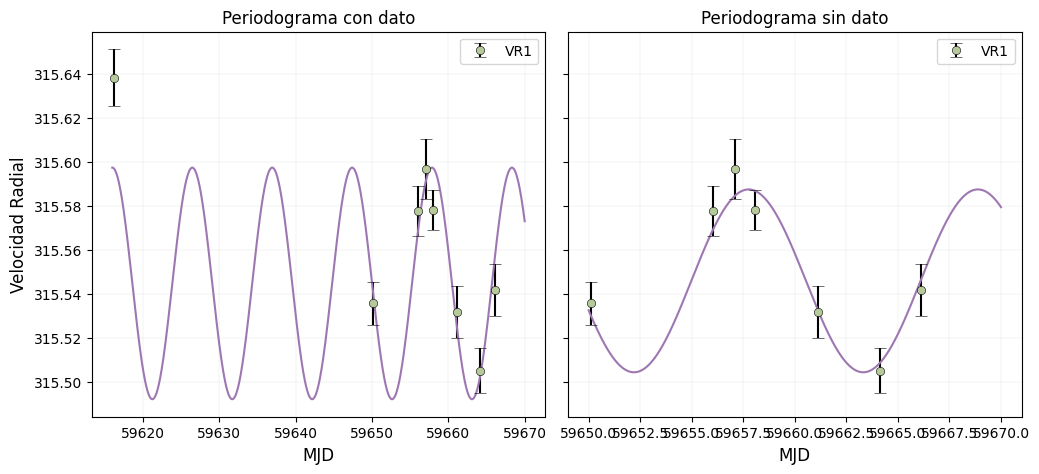

In [3]:
best_frequency_CERES = frequency_CERES[np.argmax(power_CERES)]
t_fit_CERES = np.linspace(59616,59670,1000)*u.day
ls_CERES = LombScargle(t_CERES, y_CERES, dy_CERES,  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit_CERES = ls_CERES.model(t_fit_CERES, best_frequency_CERES)

best_frequency_sin_CERES = frequency_sin_CERES[np.argmax(power_sin_CERES)]
t_fit_sin_CERES = np.linspace(59650,59670,1000)*u.day
ls_sin_CERES = LombScargle(t_CERES[1:], y_CERES[1:], dy_CERES[1:],  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit_sin_CERES = ls_sin_CERES.model(t_fit_sin_CERES, best_frequency_sin_CERES)

# Graficar el periodograma
fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.05)
(ax1,ax2) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Periodograma con dato', fontsize = 12)
ax2.set_title('Periodograma sin dato', fontsize = 12)

ax1.plot(np.array(t_fit_CERES), np.array(y_fit_CERES), '-', color = '#9E77B2', markersize = 0.5) 
ax1.errorbar(np.array(t_CERES), y_CERES.value,  yerr = dy_CERES.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')

ax2.plot(np.array(t_fit_sin_CERES), np.array(y_fit_sin_CERES), '-', color = '#9E77B2', markersize = 0.5)  
ax2.errorbar(np.array(t_CERES[1:]), y_CERES[1:].value,  yerr = dy_CERES[1:].value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')


ax1.set_xlabel('MJD',fontsize = 12)
ax1.set_ylabel('Velocidad Radial',fontsize = 12)
ax2.set_xlabel('MJD',fontsize = 12)
ax2.set_ylabel('Velocidad Radial',fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)

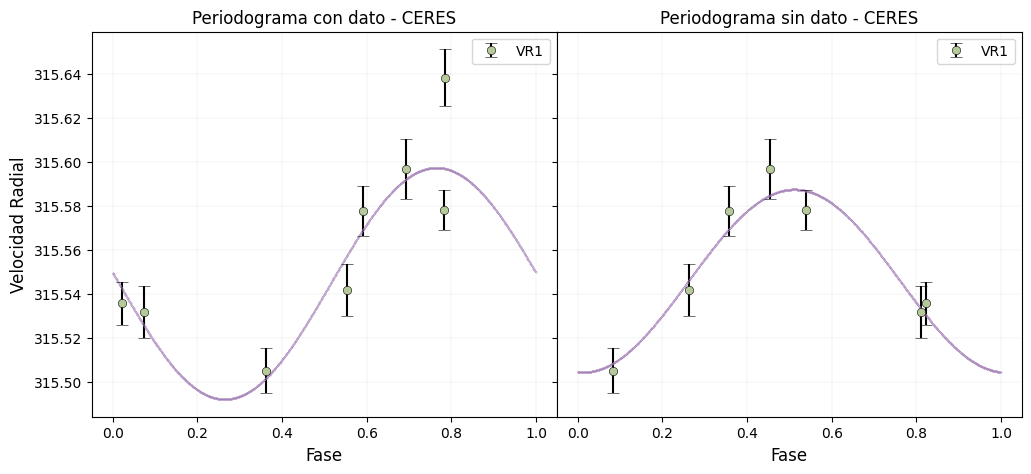

In [4]:
best_frequency_CERES = frequency_CERES[np.argmax(power_CERES)]
pt_fit_CERES = np.linspace(0,1/best_frequency_CERES.value,1000)*u.day
ls_CERES = LombScargle(t_CERES, y_CERES, dy_CERES,  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
py_fit_CERES = ls_CERES.model(pt_fit_CERES, best_frequency_CERES)

best_frequency_sin_CERES = frequency_sin_CERES[np.argmax(power_sin_CERES)]
pt_fit_sin_CERES = np.linspace(0,1/best_frequency_sin_CERES.value,1000)*u.day
ls_sin_CERES = LombScargle(t_CERES[1:], y_CERES[1:], dy_CERES[1:],  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
py_fit_sin_CERES = ls_sin_CERES.model(pt_fit_sin_CERES, best_frequency_sin_CERES)


phase_CERES = (t_CERES / p_CERES) % 1
phasefit_CERES = (pt_fit_CERES / p_CERES) %1
phase_sin_CERES = (t_CERES / p_sin_CERES) % 1
phasefit_sin_CERES = (pt_fit_sin_CERES / p_sin_CERES) %1

# Graficar el periodograma
fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0)
(ax1,ax2) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Periodograma con dato - CERES', fontsize = 12)
ax2.set_title('Periodograma sin dato - CERES', fontsize = 12)

ax1.plot(np.array(phasefit_CERES), np.array(py_fit_CERES), '.', color = '#9E77B2', markersize = 0.5) 
ax1.errorbar(np.array(phase_CERES), y_CERES.value,  yerr = dy_CERES.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')

ax2.plot(np.array(phasefit_sin_CERES), np.array(py_fit_sin_CERES), '.', color = '#9E77B2', markersize = 0.5)  
ax2.errorbar(np.array(phase_sin_CERES[1:]), y_CERES[1:].value,  yerr = dy_CERES[1:].value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')


ax1.set_xlabel('Fase',fontsize = 12)
ax1.set_ylabel('Velocidad Radial',fontsize = 12)
ax2.set_xlabel('Fase',fontsize = 12)
ax2.set_ylabel('Velocidad Radial',fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)


#### Probabilidad de falsa alarma de máximos del periodograma bajo la hipótesis nula.

Esto proporciona una estimación de la probabilidad de falsa alarma dada la altura del pico más grande en el periodograma, basada en la hipótesis nula de datos no variables con ruido gaussiano.

##### Diferentes métodos de 'False Alarm Approximations'
* **Baluev:** (Valor predeterminado) implementa la aprocimación propuesta por Baluev 2008, que emplea estadísticas de valores extremos para calcular un límite superior de la probabilidad de falsa alrarma para el caso alias-free.

* **Bootstrap:** Implementa simulación de arranque: calcula efectivamente muchos periodogramas de Lomb-Scargle sobre datos simulados en los mismos tiempos de observación. Determina con mucha precisión la probabilidad de falsa alarma.

* **Davies:** Relacionado con el método Baluev, pero pierde precisión con grandes probabilidades de falsas alarmas.

* **Naive:** Es un método básico basado en el supuesto de que las áreas bien separadas del periodograma son independientes, estimación muy pobre de la probabilidad de falsa alarma y no debe utilizarse en la práctica.

**En general, los usuarios deben utilizar el enfoque bootstrap cuando sea computacionalmente factible y el enfoque Baluev en caso contrario.**

In [5]:
print("-"*80)
print("Valor del máximo pico: ", power_CERES.max())
print("Diferentes Métodos de 'False Alarm Approximations' con dato")
print("baluev: ",ls_CERES.false_alarm_probability(power_CERES.max(),method='baluev', maximum_frequency = frequency_CERES.max()))
print("\x1b[1;35m"+f"bootstrap: {ls_CERES.false_alarm_probability(power_CERES.max(),method='bootstrap', maximum_frequency = frequency_CERES.max())}"+"\033[0m")
print("davies: ",ls_CERES.false_alarm_probability(power_CERES.max(),method='davies', maximum_frequency = frequency_CERES.max()))
print("naive: ",ls_CERES.false_alarm_probability(power_CERES.max(), method='naive', maximum_frequency = frequency_CERES.max()))
print("-"*80)
print("Valor del máximo pico: ", power_sin_CERES.max())
print("Diferentes Métodos de 'False Alarm Approximations' sin dato")
print("baluev: ",ls_sin_CERES.false_alarm_probability(power_sin_CERES.max(),method='baluev', maximum_frequency = frequency_sin_CERES.max()))
print("\x1b[1;35m"+f"bootstrap: {ls_sin_CERES.false_alarm_probability(power_sin_CERES.max(),method='bootstrap', maximum_frequency = frequency_sin_CERES.max())}"+"\033[0m")
print("davies: ",ls_sin_CERES.false_alarm_probability(power_sin_CERES.max(),method='davies', maximum_frequency = frequency_sin_CERES.max()))
print("naive: ",ls_sin_CERES.false_alarm_probability(power_sin_CERES.max(), method='naive', maximum_frequency = frequency_sin_CERES.max()))
print("-"*80)

--------------------------------------------------------------------------------
Valor del máximo pico:  4.235728738100182
Diferentes Métodos de 'False Alarm Approximations' con dato
baluev:  0.36829546960112064
bootstrap: 0.34299999999999997
davies:  0.4592050602343373
naive:  0.16068872769849118
--------------------------------------------------------------------------------
Valor del máximo pico:  17.434465134596195
Diferentes Métodos de 'False Alarm Approximations' sin dato
baluev:  0.05636343667736704
bootstrap: 0.050000000000000044
davies:  0.05800984533396884
naive:  0.010261454002466445
--------------------------------------------------------------------------------


## Simulaciones Monte Carlo:
Para darle peso a los resultados obtenidos, debido a que son pocos datos, es importante entonces realizar un proceso estadístico que me permita recrear los datos N veces, para de esta forma darle un peso mayor a los resultados obtenidos.

Primero vamos a estimar la discrepancia entre el valor que tengo como observación (medido) y el valor que me arroja el modelo. Necesitamos saber si eso fluctua gaussianamente para poder hacer, es decir, hacer un test de gaussianidad con estos valores.

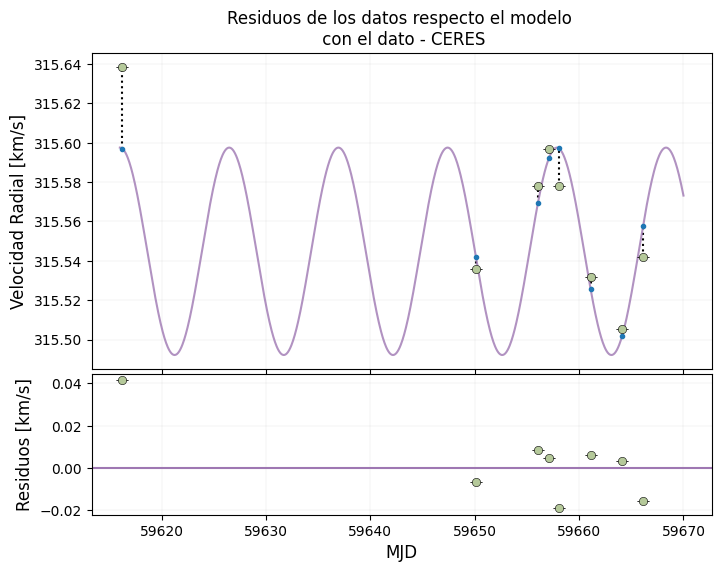

In [6]:
v_int_CERES = []
for i in t_CERES.value:
    v_int_CERES.append(np.interp(i, t_fit_CERES.value, y_fit_CERES.value))
y_new_CERES = y_CERES.value - v_int_CERES


fig, ax = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.02}
)

# Graficando los residuos.
ax[0].plot(np.array(t_fit_CERES), np.array(y_fit_CERES), '-', color = '#9E77B2', markersize = 0.5, alpha=0.8) 

n  = len(t_CERES.value)

for i in range(0,n,1):
    y0_CERES = np.min([y_CERES.value[i],v_int_CERES[i]])
    y1_CERES = np.max([y_CERES.value[i],v_int_CERES[i]])
    ax[0].vlines(t_CERES.value[i],y0_CERES,y1_CERES, color='k',
               linestyle ='dotted')
ax[0].set_title("Residuos de los datos respecto el modelo \n con el dato - CERES")
ax[0].plot(t_CERES, v_int_CERES,'.')
ax[0].errorbar(t_CERES.value, y_CERES.value,  yerr = 0, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')
ax[0].set_ylabel('Velocidad Radial [km/s]',fontsize = 12)

ax[1].errorbar(t_CERES.value, y_new_CERES, yerr=0,linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')
ax[1].axhline(0, color="#9E77B2")
ax[1].set_xlabel('MJD',fontsize = 12)
ax[1].set_ylabel("Residuos [km/s]",fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)


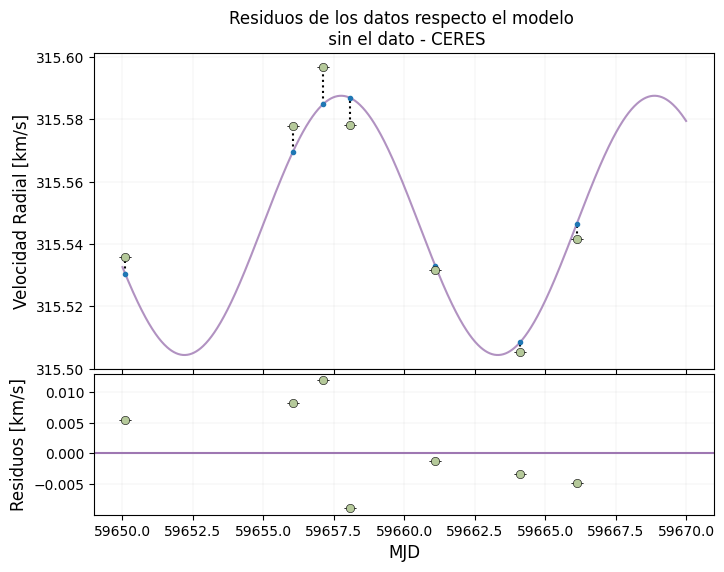

In [7]:
v_int_sin_CERES = []
for i in t_CERES[1:].value:
    v_int_sin_CERES.append(np.interp(i, t_fit_sin_CERES.value, y_fit_sin_CERES.value))
y_new_sin_CERES = y_CERES[1:].value - v_int_sin_CERES


fig, ax = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.02}
)

# Graficando los residuos.
ax[0].plot(np.array(t_fit_sin_CERES), np.array(y_fit_sin_CERES), '-', color = '#9E77B2', markersize = 0.5, alpha=0.8) 

n  = len(t_CERES[1:].value)

for i in range(0,n,1):
    y0_sin_CERES = np.min([y_CERES[1:].value[i],v_int_sin_CERES[i]])
    y1_sin_CERES = np.max([y_CERES[1:].value[i],v_int_sin_CERES[i]])
    ax[0].vlines(t_CERES[1:].value[i],y0_sin_CERES,y1_sin_CERES, color='k',
               linestyle ='dotted')
    
ax[0].set_title("Residuos de los datos respecto el modelo \n sin el dato - CERES")
ax[0].plot(t_CERES[1:], v_int_sin_CERES,'.')
ax[0].errorbar(t_CERES[1:].value, y_CERES[1:].value,  yerr = 0, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')
ax[0].set_ylabel('Velocidad Radial [km/s]',fontsize = 12)

ax[1].errorbar(t_CERES[1:].value, y_new_sin_CERES, yerr=0,linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')
ax[1].axhline(0, color="#9E77B2")
ax[1].set_xlabel('MJD',fontsize = 12)
ax[1].set_ylabel("Residuos [km/s]",fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)


Supongamos que deseamos probar la hipótesis nula de que las diferencias vienen de la misma distribución (distribución normal). Elegimos un nivel de confianza del 95%; es decir, rechazaremos la hipótesis nula a favor de la alternativa si el valor p es menor que 0,05.

In [8]:
y_new_CERES = np.array(y_CERES.value - v_int_CERES)
print(y_new_CERES)

mu, sigma = 0, 1 # media y desviación estándar
num_samples = len(y_new_CERES) # usar la misma cantidad de muestras que tu conjunto de datos

# Generar una muestra de datos de la distribución normal
normal_data = np.random.normal(mu, sigma, 1000000)

print("k test para datos de la diferencia entre el dato y la función: \n",ks_2samp(y_new_CERES, normal_data))

[ 0.04134937 -0.0064465   0.00859846  0.00447181 -0.01905496  0.00613437
  0.00343379 -0.01578181]
k test para datos de la diferencia entre el dato y la función: 
 KstestResult(statistic=0.492754, pvalue=0.025786746895468116, statistic_location=-0.019056630468421806, statistic_sign=-1)


#### Con el Dato

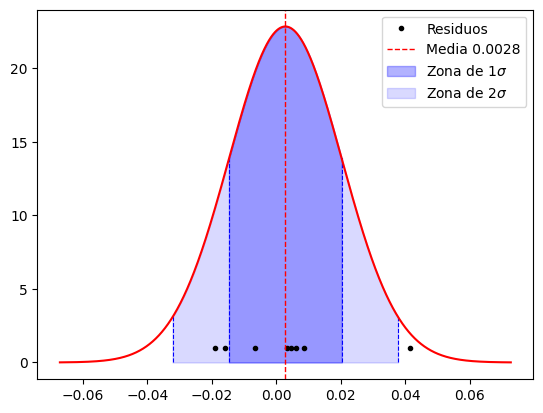

In [9]:
plt.plot(y_new_CERES,[1,1,1,1,1,1,1,1], '.', color = 'k', label = 'Residuos')
media_CERES = np.mean(y_new_CERES)  # Media del ruido
σ_CERES =np.sqrt(np.var(y_new_CERES))  # Desviación estándar del ruido
# Generar el ruido gaussiano
x_0s_CERES=np.linspace(-4*σ_CERES+media_CERES,4*σ_CERES+media_CERES,num=100000)
y_0s_CERES=stats.norm.pdf(x_0s_CERES,media_CERES,σ_CERES)

plt.plot(x_0s_CERES,y_0s_CERES,'r')
plt.axvline(media_CERES, color = "red", linewidth = 1, linestyle = "dashed", label = f'Media {round(media_CERES,4)}')

x_1s_CERES = np.linspace(-1*σ_CERES+media_CERES,1*σ_CERES+media_CERES,num=100000)
y_1s_CERES = stats.norm.pdf(x_1s_CERES,media_CERES,σ_CERES)
plt.fill_between(x_1s_CERES,y_1s_CERES, color = 'b', alpha=0.3,label='Zona de $1\sigma$')
plt.vlines(x=-1*σ_CERES+media_CERES, ymin=0, ymax=14.05, linestyles ='--', color = 'b', linewidth = 0.8)
plt.vlines(x=1*σ_CERES+media_CERES, ymin=0, ymax=14.05, linestyles ='--', color = 'b', linewidth = 0.8)

x_2s_CERES = np.linspace(-2*σ_CERES+media_CERES,2*σ_CERES+media_CERES,num=100000)
y_2s_CERES = stats.norm.pdf(x_2s_CERES,media_CERES,σ_CERES)
plt.fill_between(x_2s_CERES,y_2s_CERES, color = 'b', alpha=0.15,label='Zona de $2\sigma$')
plt.vlines(x=-2*σ_CERES+media_CERES, ymin=0, ymax=3.25, linestyles ='--', color = 'b', linewidth = 0.8)
plt.vlines(x=2*σ_CERES+media_CERES, ymin=0, ymax=3.25, linestyles ='--', color = 'b', linewidth = 0.8)


plt.legend()

In [10]:
print("La desviación estándar estimada es: ", σ_CERES)

La desviación estándar estimada es:  0.017472836595661317


In [11]:
# Tu conjunto de datos original (por ejemplo)
datos_originales_CERES = y_fit_CERES  # Inserta tus datos reales aquí
tiempos_originales_CERES = t_fit_CERES

# Número de experimentos de Monte Carlo
num_experimentos_CERES = 100000

# Número de puntos en cada experimento
num_puntos_CERES = 8

# Generar N experimentos de Monte Carlo
experimentos_mc_CERES = []
tiempos_mc_CERES = []

for _ in tqdm(range(num_experimentos_CERES)):
    # Seleccionar aleatoriamente 8 puntos del conjunto de datos original
    indices_aleatorios_CERES = np.random.choice(len(datos_originales_CERES), size=num_puntos_CERES, replace=False)
    datos_experimento_CERES = datos_originales_CERES[indices_aleatorios_CERES]
    experimentos_mc_CERES.append(datos_experimento_CERES)

    # Agregando los tiempos aleatorios  
    #indices_aleatorios = np.random.choice(len(tiempos_originales), size=num_puntos, replace=False)
    tiempos_experimento_CERES = tiempos_originales_CERES[indices_aleatorios_CERES]
    tiempos_mc_CERES.append(tiempos_experimento_CERES)

# Convertir la lista de experimentos en un arreglo numpy
experimentos_mc_CERES = np.array(experimentos_mc_CERES)
tiempos_mc_CERES = np.array(tiempos_mc_CERES)

# Verificar la forma de los datos generados
print("Forma de los datos generados:", experimentos_mc_CERES.shape)
print("Forma de los datos de tiempo generados:", tiempos_mc_CERES.shape)


100%|████████████████████████████████| 100000/100000 [00:05<00:00, 17139.25it/s]


Forma de los datos generados: (100000, 8)
Forma de los datos de tiempo generados: (100000, 8)


In [12]:
f_montecarlo_CERES = []
p_montecarlo_CERES = []
FAP_CERES = []

for i in tqdm(range(len(experimentos_mc_CERES))):
    # Parámetros del ruido gaussiano
    media_CERES = 0  # Media del ruido
    desviacion_estandar_CERES = σ_CERES
  # Desviación estándar del ruido
    
    # Generar el ruido gaussiano
    ruido_CERES = np.random.normal(media_CERES, desviacion_estandar_CERES, num_puntos_CERES)
    
    # Agregar el ruido a la señal
    experimentos_mc_ruido_CERES = experimentos_mc_CERES[i] + ruido_CERES
    frequency_CERES, power_CERES = LombScargle(tiempos_mc_CERES[i]*u.d, experimentos_mc_ruido_CERES*u.km/u.s,normalization='model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')
    f_montecarlo_CERES.append(frequency_CERES[np.argmax(power_CERES)])
    p_montecarlo_CERES.append(1/frequency_CERES[np.argmax(power_CERES)])

    # best_frequency = frequency[np.argmax(power)]
    # t_fit = np.linspace(59616,59666.25,1000)*u.day
    # ls = LombScargle(t, y, dy, fit_mean=True, center_data=True,normalization='model')
    # y_fit = ls.model(t_fit, best_frequency)
    # FAP.append(ls.false_alarm_probability(power.max(),method='bootstrap', maximum_frequency = frequency.max()))

100%|███████████████████████████████████| 100000/100000 [46:47<00:00, 35.62it/s]


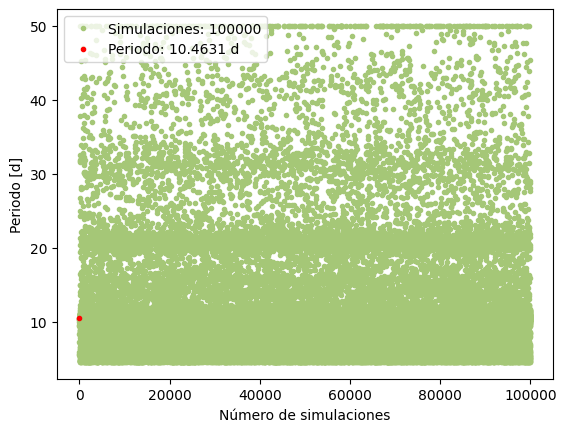

In [16]:
periodos_monte_carlo_CERES = [dato_CERES.value for dato_CERES in p_montecarlo_CERES]

plt.plot(periodos_monte_carlo_CERES,'.', color = '#A5C777', label = f'Simulaciones: {len(periodos_monte_carlo_CERES)}')
plt.plot(p_CERES, '.', color = 'r',  label = f'Periodo: {np.round(p_CERES,4)}')

plt.xlabel("Número de simulaciones")
plt.ylabel("Periodo [d]")
plt.legend()
#plt.legend(bbox_to_anchor=(0.8, 0.5, 0.65, 0.5))

In [17]:
nuevos_p_monte_carlo_CERES = []
nueva_FAP_CERES = []

for i in range(len(periodos_monte_carlo_CERES)):
    if periodos_monte_carlo_CERES[i] <= 55:
        nuevos_p_monte_carlo_CERES.append(periodos_monte_carlo_CERES[i])
        #nueva_FAP.append(FAP[i])


In [18]:
print("Simulaciones aceptadas: ",len(nuevos_p_monte_carlo_CERES))

Simulaciones aceptadas:  100000


In [19]:
def doane_bins(datos):
    """
    Calcula el número de bins para un histograma utilizando la regla de Doane.
    La regla de Doane ajusta el número de bins para tener en cuenta el sesgo (skewness) de la distribución de los datos.
    Parámetros:
    -----------
    datos : array-like
        Los datos de los cuales se desea calcular el número de bins.
    Retorna:
    --------
    numero_bins : int
        El número de bins calculado según la regla de Doane.
    """
    datos = np.asarray(datos)
    n = len(datos)
    skewness = stats.skew(datos)
    se_skewness = np.sqrt((6 * (n - 2)) / ((n + 1) * (n + 3)))
    numero_bins = 1 + math.log2(n) + math.log2(1 + (abs(skewness) / se_skewness))
    return int(numero_bins)

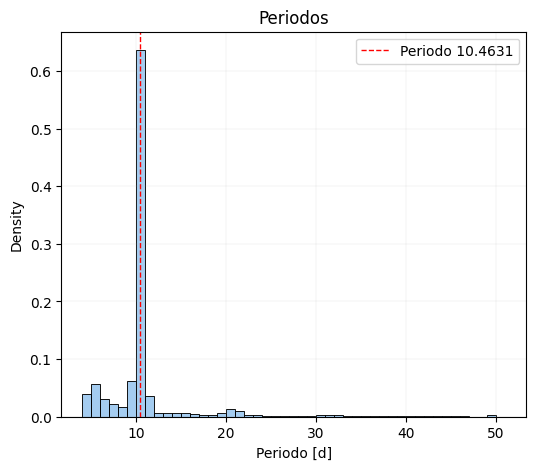

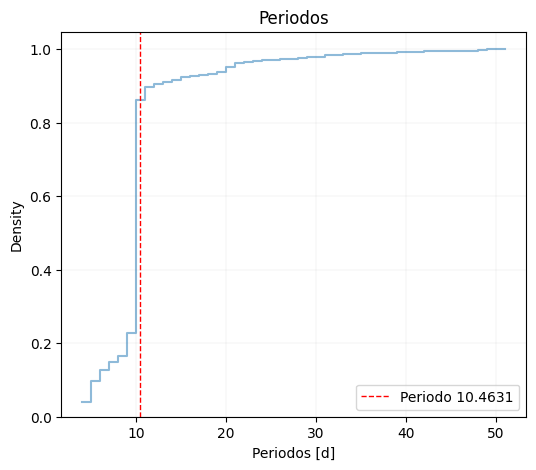

In [20]:
dist_CERES = np.array(nuevos_p_monte_carlo_CERES)
dist_CERES = pd.Series(dist_CERES, name = "Numerical Variable")

plt.figure(figsize=(6,5))
plt.xlabel('Periodo [d]')
#plt.ylabel('Velocidad Radial')
plt.title('Periodos')
sns.histplot(dist_CERES,stat='density', bins = doane_bins(dist_CERES),alpha=0.5, cumulative=False, element='bars', discrete = True, color = '#4B9BE2')
plt.axvline(p_CERES.value, color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {round(p_CERES.value,4)}')
#dist.plot.kde(color = '#8a226a', linewidth = 1)
#plt.xlim(0,40)
plt.grid(linestyle='-', linewidth=0.1)
plt.legend()
#plt.ylim(0,0.1)
plt.show()

#Valor fijo para los bins

plt.figure(figsize=(6,5))
plt.xlabel('Periodos [d]')
plt.ylabel('')
plt.title('Periodos')
sns.histplot(dist_CERES,stat='density', bins = doane_bins(dist_CERES),alpha=0.5, cumulative=True, element='step', fill = False, discrete = True)
plt.axvline(p_CERES.value, color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {round(p_CERES.value,4)}')
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()


# dist = np.array(nueva_FAP)
# plt.figure(figsize=(6,5))
# plt.xlabel('Values')
# #plt.ylabel('Velocidad Radial')
# plt.title('FAP (Probabilidad de Falsa Alarma)')
# sns.histplot(dist, bins = 50,alpha=0.5)
# plt.grid(linestyle='-', linewidth=0.1)
# plt.show()

#### Sin el Dato

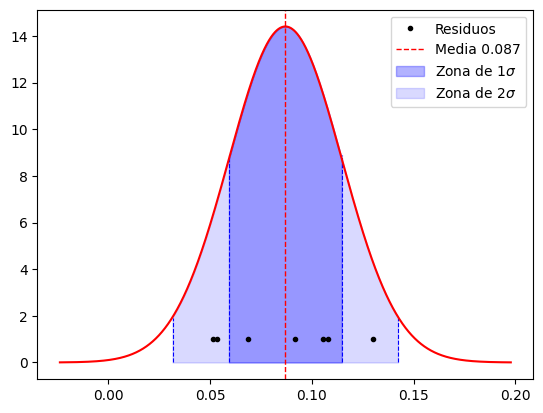

In [40]:
plt.plot(y_new_sin_CERES,[1,1,1,1,1,1,1], '.', color = 'k', label = 'Residuos')
media_sin_CERES = np.mean(y_new_sin_CERES)  # Media del ruido
σ_sin_CERES =np.sqrt(np.var(y_new_sin_CERES))  # Desviación estándar del ruido
# Generar el ruido gaussiano
x_0s_sin_CERES=np.linspace(-4*σ_sin_CERES+media_sin_CERES,4*σ_sin_CERES+media_sin_CERES,num=100000)
y_0s_sin_CERES=stats.norm.pdf(x_0s_sin_CERES,media_sin_CERES,σ_sin_CERES)

plt.plot(x_0s_sin_CERES,y_0s_sin_CERES,'r')
plt.axvline(media_sin_CERES, color = "red", linewidth = 1, linestyle = "dashed", label = f'Media {round(media_sin_CERES,4)}')

x_1s_sin_CERES = np.linspace(-1*σ_sin_CERES+media_sin_CERES,1*σ_sin_CERES+media_sin_CERES,num=100000)
y_1s_sin_CERES = stats.norm.pdf(x_1s_sin_CERES,media_sin_CERES,σ_sin_CERES)
plt.fill_between(x_1s_sin_CERES,y_1s_sin_CERES, color = 'b', alpha=0.3,label='Zona de $1\sigma$')
plt.vlines(x=-1*σ_sin_CERES+media_sin_CERES, ymin=0, ymax=8.9, linestyles ='--', color = 'b', linewidth = 0.8)
plt.vlines(x=1*σ_sin_CERES+media_sin_CERES, ymin=0, ymax=8.9, linestyles ='--', color = 'b', linewidth = 0.8)

x_2s_sin_CERES = np.linspace(-2*σ_sin_CERES+media_sin_CERES,2*σ_sin_CERES+media_sin_CERES,num=100000)
y_2s_sin_CERES = stats.norm.pdf(x_2s_sin_CERES,media_sin_CERES,σ_sin_CERES)
plt.fill_between(x_2s_sin_CERES,y_2s_sin_CERES, color = 'b', alpha=0.15,label='Zona de $2\sigma$')
plt.vlines(x=-2*σ_sin_CERES+media_sin_CERES, ymin=0, ymax=1.9, linestyles ='--', color = 'b', linewidth = 0.8)
plt.vlines(x=2*σ_sin_CERES+media_sin_CERES, ymin=0, ymax=1.9, linestyles ='--', color = 'b', linewidth = 0.8)

plt.legend()

In [41]:
print("La desviación estándar estimada es: ", σ_sin_CERES)

La desviación estándar estimada es:  0.02768872101387936


In [42]:
# Tu conjunto de datos original (por ejemplo)
datos_originales_sin_CERES = y_fit_sin_CERES  # Inserta tus datos reales aquí
tiempos_originales_sin_CERES = t_fit_sin_CERES

# Número de experimentos de Monte Carlo
num_experimentos_sin_CERES = 100000

# Número de puntos en cada experimento
num_puntos_sin_CERES = 8

# Generar N experimentos de Monte Carlo
experimentos_mc_sin_CERES = []
tiempos_mc_sin_CERES = []

for _ in tqdm(range(num_experimentos_sin_CERES)):
    # Seleccionar aleatoriamente 8 puntos del conjunto de datos original
    indices_aleatorios_sin_CERES = np.random.choice(len(datos_originales_sin_CERES), size=num_puntos_sin_CERES, replace=False)
    datos_experimento_sin_CERES = datos_originales_sin_CERES[indices_aleatorios_sin_CERES]
    experimentos_mc_sin_CERES.append(datos_experimento_sin_CERES)

    # Agregando los tiempos aleatorios  
    #indices_aleatorios = np.random.choice(len(tiempos_originales), size=num_puntos, replace=False)
    tiempos_experimento_sin_CERES = tiempos_originales_sin_CERES[indices_aleatorios_sin_CERES]
    tiempos_mc_sin_CERES.append(tiempos_experimento_sin_CERES)

# Convertir la lista de experimentos en un arreglo numpy
experimentos_mc_sin_CERES = np.array(experimentos_mc_sin_CERES)
tiempos_mc_sin_CERES = np.array(tiempos_mc_sin_CERES)

# Verificar la forma de los datos generados
print("Forma de los datos generados:", experimentos_mc_sin_CERES.shape)
print("Forma de los datos de tiempo generados:", tiempos_mc_sin_CERES.shape)


100%|████████████████████████████████| 100000/100000 [00:05<00:00, 17212.57it/s]


Forma de los datos generados: (100000, 8)
Forma de los datos de tiempo generados: (100000, 8)


In [43]:
f_montecarlo_sin_CERES = []
p_montecarlo_sin_CERES = []
FAP_sin_CERES = []

for i in tqdm(range(len(experimentos_mc_sin_CERES))):
    # Parámetros del ruido gaussiano
    media_sin_CERES = 0  # Media del ruido
    desviacion_estandar_sin_CERES = σ_sin_CERES
  # Desviación estándar del ruido
    
    # Generar el ruido gaussiano
    ruido_sin_CERES = np.random.normal(media_sin_CERES, desviacion_estandar_sin_CERES, num_puntos_sin_CERES)
    
    # Agregar el ruido a la señal
    experimentos_mc_ruido_sin_CERES = experimentos_mc_sin_CERES[i] + ruido_sin_CERES
    frequency_sin_CERES, power_sin_CERES = LombScargle(tiempos_mc_sin_CERES[i]*u.d, experimentos_mc_ruido_sin_CERES*u.km/u.s,normalization='model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')
    f_montecarlo_sin_CERES.append(frequency_sin_CERES[np.argmax(power_sin_CERES)])
    p_montecarlo_sin_CERES.append(1/frequency_sin_CERES[np.argmax(power_sin_CERES)])

    # best_frequency = frequency[np.argmax(power)]
    # t_fit = np.linspace(59616,59666.25,1000)*u.day
    # ls = LombScargle(t, y, dy, fit_mean=True, center_data=True,normalization='model')
    # y_fit = ls.model(t_fit, best_frequency)
    # FAP.append(ls.false_alarm_probability(power.max(),method='bootstrap', maximum_frequency = frequency.max()))

100%|███████████████████████████████████| 100000/100000 [19:29<00:00, 85.51it/s]


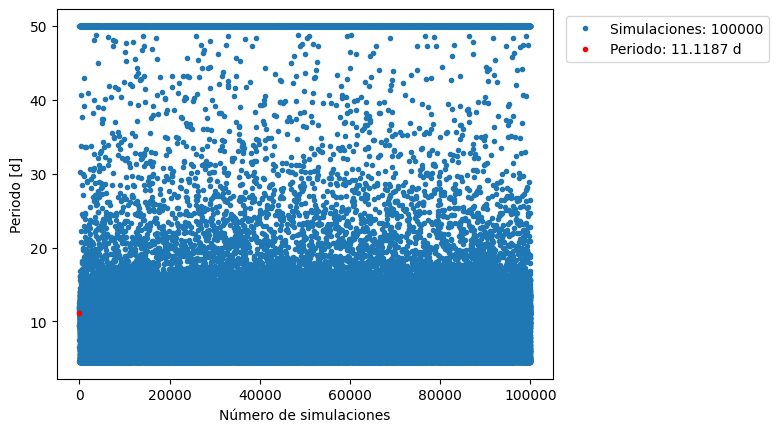

In [45]:
periodos_monte_carlo_sin_CERES = [dato_sin_CERES.value for dato_sin_CERES in p_montecarlo_sin_CERES]

plt.plot(periodos_monte_carlo_sin_CERES,'.', label = f'Simulaciones: {len(periodos_monte_carlo_sin_CERES)}')
plt.plot(p_sin_CERES, '.', color = 'r',  label = f'Periodo: {np.round(p_sin_CERES,4)}')

plt.xlabel("Número de simulaciones")
plt.ylabel("Periodo [d]")
plt.legend(bbox_to_anchor=(0.8, 0.5, 0.65, 0.5))

In [51]:
nuevos_p_monte_carlo_sin_CERES = []
nueva_FAP_sin_CERES = []

for i in range(len(periodos_monte_carlo_sin_CERES)):
    if periodos_monte_carlo_sin_CERES[i] <= 49:
        nuevos_p_monte_carlo_sin_CERES.append(periodos_monte_carlo_sin_CERES[i])
        #nueva_FAP.append(FAP[i])


In [52]:
print("Simulaciones aceptadas: ",len(nuevos_p_monte_carlo_sin_CERES))

Simulaciones aceptadas:  95767


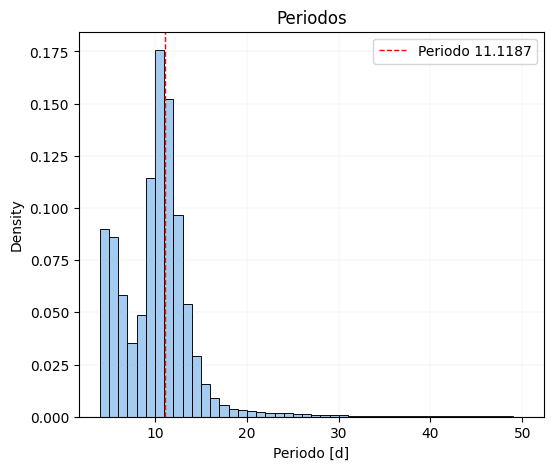

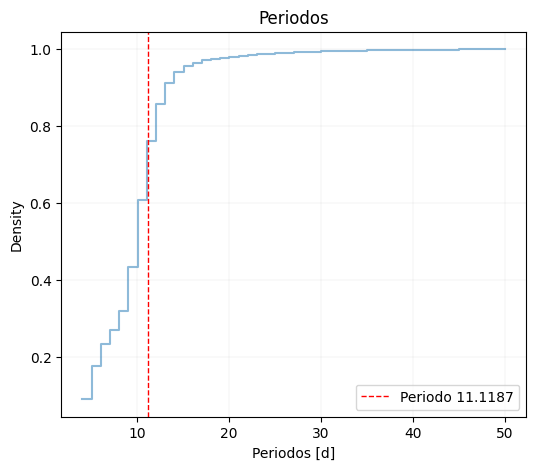

In [53]:
dist_sin_CERES = np.array(nuevos_p_monte_carlo_sin_CERES)
dist_sin_CERES = pd.Series(dist_sin_CERES, name = "Numerical Variable")

plt.figure(figsize=(6,5))
plt.xlabel('Periodo [d]')
#plt.ylabel('Velocidad Radial')
plt.title('Periodos')
sns.histplot(dist_sin_CERES,stat='density', bins = doane_bins(dist_sin_CERES),alpha=0.5, cumulative=False, element='bars', discrete = True, color = '#4B9BE2')
plt.axvline(p_sin_CERES.value, color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {round(p_sin_CERES.value,4)}')
#dist.plot.kde(color = '#8a226a', linewidth = 1)
#plt.xlim(0,40)
plt.grid(linestyle='-', linewidth=0.1)
plt.legend()
#plt.ylim(0,0.1)
plt.show()

#Valor fijo para los bins

plt.figure(figsize=(6,5))
plt.xlabel('Periodos [d]')
plt.ylabel('')
plt.title('Periodos')
sns.histplot(dist_sin_CERES,stat='density', bins = doane_bins(dist_sin_CERES),alpha=0.5, cumulative=True, element='step', fill = False, discrete = True)
plt.axvline(p_sin_CERES.value, color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {round(p_sin_CERES.value,4)}')
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()


# dist = np.array(nueva_FAP)
# plt.figure(figsize=(6,5))
# plt.xlabel('Values')
# #plt.ylabel('Velocidad Radial')
# plt.title('FAP (Probabilidad de Falsa Alarma)')
# sns.histplot(dist, bins = 50,alpha=0.5)
# plt.grid(linestyle='-', linewidth=0.1)
# plt.show()